# Ensemble with Meta Model = LSTM, CNN, ATT, TF
Create: 06/12/2022
Description: Ensemble - Combination of Data and Staking Model by LSTM, CNN, ATT, TF. Data from 1997-2015. 44 validation
Modification: 31/01/2023

In [1]:
!nvidia-smi

Tue Jan 31 07:53:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:21:00.0 Off |                  Off |
| 34%   36C    P8    22W / 260W |      3MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install packages
# !pip install -U scikit-learn
# !pip install ftfy
# !pip install xlsxwriter 
# !pip install xlwt

# Imports

In [3]:
# Imports
import tensorflow as tf 
# from google.colab import drive
import os

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense

import traceback
import sys
import copy
import numpy as np
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# lib for LSTM of Meta model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from ftfy import fix_text
import warnings
warnings.simplefilter("ignore", UserWarning)

plt.rcParams['figure.figsize'] = [7, 3]
import math

# Global param and project path

In [4]:
# Attach Google Drive for reading and saving files
# drive.mount('/content/drive')
prj_path = '/home/mlworker/Quang/HealthCare/Source_14012023_v4/'

path_all_mix_data =             prj_path+ '/results/all_mix_data/'
path_all_mix_data_cnn =         path_all_mix_data + "/cnn/"
path_all_mix_data_lstm =        path_all_mix_data + "/lstm/"
path_all_mix_data_lstm_att =    path_all_mix_data + "/lstm_att/"
path_all_mix_data_tf =          path_all_mix_data + "/tf/"

prj_path_opt= prj_path+ '/optimize_hyperparam/opt_results/'

prj_path_result_ensemble = prj_path+ '/results/ensemble/'
com_path =      prj_path_result_ensemble+ '/all_combinations_1.xlsx'
com_path_2 =    prj_path_result_ensemble+ '/all_combinations_2.xlsx'
com_path_3 =    prj_path_result_ensemble+ '/all_combinations_3.xlsx'
com_path_4 =    prj_path_result_ensemble+ '/all_combinations_4.xlsx'

com_path_metrics =      prj_path_result_ensemble+ '/all_combinations_metrics_1.xlsx'
com_path_metrics_2 =    prj_path_result_ensemble+ '/all_combinations_metrics_2.xlsx'
com_path_metrics_3 =    prj_path_result_ensemble+ '/all_combinations_metrics_3.xlsx'
com_path_metrics_4 =    prj_path_result_ensemble+ '/all_combinations_metrics_4.xlsx'



# os.chdir(prj_path)

# loockback_window for meta model. default = 3 months for alls
meta_lookback_window = 3
len_validation = 24 # validation or test depends on usecase

#Note: mỗi bộ all_mix_data sẽ có lenght = 251 (1997 -01/01/2018  và vì 1 dòng đầu bị bỏ đi do quá trình statitionary và remove NAN lúc train)
lenght_whole_data_city = 227

<AxesSubplot:>

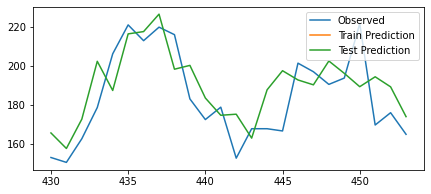

In [5]:
city = 'Cao Bằng'
df = pd.read_excel(path_all_mix_data_cnn+'mix_train_test_data_'+city+'_cnn.xlsx')
selected_result = df.sort_values(by = 'rmse', ascending=True) # Sắp xếp theo rmse nhỏ nhất
selected_result = selected_result.head(227) # lấy 227 phần tử đầu tiên
selected_result= selected_result.sort_index() 
cols = ['Observed','Train Prediction','Test Prediction']
selected_result[cols].iloc[-len_validation:].plot()

# Xây dựng Meta Data Set

In [6]:
##########################
# Xây Dựng Meta Data Set
meta_test_set_city = {}
meta_train_set_city = {}
meta_data_set_city = {}
cities = [
            'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng',
#         'Cà Mau',
#         'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
#         'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
#         'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
#         'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
#         'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
#         'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
#         'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
#         'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
#          'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
        ]

for city in cities:  
  meta_test_set = pd.DataFrame()
  meta_train_set = pd.DataFrame() 
  
  
  ######################################
  # Xử lý data của CNN ứng với mỗi city
  df = pd.read_excel(path_all_mix_data_cnn+'mix_train_test_data_'+city+'_cnn.xlsx')
  selected_result = df.sort_values(by = 'rmse', ascending=True) # Sắp xếp theo rmse nhỏ nhất
  selected_result = selected_result.head(lenght_whole_data_city) # lấy 251 phần tử đầu tiên
  selected_result= selected_result.sort_index() 
  # Tạo meta testset
  result_test = selected_result['Train Prediction'].iloc[-meta_lookback_window-len_validation:-len_validation] # Lấy buffer cho phần lookback_window
  result_test = result_test.append(selected_result['Test Prediction'].tail(len_validation))
  meta_test_cnn = result_test.reset_index(drop=True)  
  # Tạo meta trainset
  result_train = selected_result['Train Prediction'].iloc[meta_lookback_window:-len_validation]
  meta_train_cnn = result_train.reset_index(drop=True)
  
  ######################################
  # Xử lý data của LSTM  ứng với mỗi city
  df = pd.read_excel(path_all_mix_data_lstm+'mix_train_test_data_'+city+'_lstm.xlsx')  
  selected_result = df.sort_values(by = 'rmse', ascending=True) # Sắp xếp theo rmse nhỏ nhất
  selected_result = selected_result.head(lenght_whole_data_city) # lấy 251 phần tử đầu tiên
  selected_result= selected_result.sort_index()   
  
  # Tạo meta testset
  result_test = selected_result['Train Prediction'].iloc[-meta_lookback_window-len_validation:-len_validation] # Lấy buffer cho phần lookback_window
  result_test = result_test.append(selected_result['Test Prediction'].tail(len_validation))
  meta_test_lstm = result_test.reset_index(drop=True)
  # Tạo meta trainset
  result_train = selected_result['Train Prediction'].iloc[meta_lookback_window:-len_validation]
  meta_train_lstm = result_train.reset_index(drop=True)

  ###########################################
  # Xử lý data của LSTM ATT ứng với mỗi city
  df = pd.read_excel(path_all_mix_data_lstm_att+'mix_train_test_data_'+city+'_lstm_att.xlsx') 
  selected_result = df.sort_values(by = 'rmse', ascending=True) # Sắp xếp theo rmse nhỏ nhất
  selected_result = selected_result.head(lenght_whole_data_city) # lấy 251 phần tử đầu tiên
  selected_result= selected_result.sort_index()   
  
  # Tạo meta testset
  # Meta testset sẽ có lenght = 36 + lookback_window   
  result_test = selected_result['Train Prediction'].iloc[-meta_lookback_window-len_validation:-len_validation] # Lấy buffer cho phần lookback_window
  result_test = result_test.append(selected_result['Test Prediction'].tail(len_validation))
  meta_test_lstm_att = result_test.reset_index(drop=True)  
  
  # Tạo meta trainset  
  result_train = selected_result['Train Prediction'].iloc[meta_lookback_window:-len_validation]
  meta_train_lstm_att = result_train.reset_index(drop=True)

  # lấy observation
  meta_test_observed = selected_result['Observed'].iloc[-meta_lookback_window-len_validation:]
  meta_test_observed = meta_test_observed.reset_index(drop=True) 
  meta_train_observed = selected_result['Observed'].iloc[meta_lookback_window:-len_validation]
  meta_train_observed = meta_train_observed.reset_index(drop=True)

  #############################################
  # # Xử lý data của Transformer ứng với mỗi city
  df = pd.read_excel(path_all_mix_data_tf+'mix_train_test_data_'+city+'_tf.xlsx') 
  selected_result = df.sort_values(by = 'rmse', ascending=True) # Sắp xếp theo rmse nhỏ nhất
  selected_result = selected_result.head(lenght_whole_data_city) # lấy 251 phần tử đầu tiên
  selected_result= selected_result.sort_index()   
  
  # Tạo meta testset
  # Meta testset sẽ có lenght = 36 + lookback_window 
  result_test = selected_result['Train Prediction'].iloc[-meta_lookback_window-len_validation:-len_validation] # Lấy buffer cho phần lookback_window
  result_test = result_test.append(selected_result['Test Prediction'].tail(len_validation)) # Lấy 36 tháng cuối
  meta_test_tf = result_test.reset_index(drop=True)  
  
  # Tạo meta trainset
  result_train = selected_result['Train Prediction'].iloc[meta_lookback_window:-len_validation]
  meta_train_tf = result_train.reset_index(drop=True)

  
  meta_test_set['cnn_pred'] = meta_test_cnn
  meta_test_set['lstm_pred'] = meta_test_lstm
  meta_test_set['lstm_att_pred'] = meta_test_lstm_att
  meta_test_set['tf_pred'] = meta_test_tf
  meta_test_set['Observed'] = meta_test_observed
   
  meta_train_set['cnn_pred'] = meta_train_cnn
  meta_train_set['lstm_pred'] = meta_train_lstm
  meta_train_set['lstm_att_pred'] = meta_train_lstm_att 
  meta_train_set['tf_pred'] = meta_train_tf  
  meta_train_set['Observed'] = meta_train_observed

  meta_test_set_city[city] = meta_test_set # test set có chiều dài 39
  meta_train_set_city[city] = meta_train_set # train set có chiều dài 212 = 252 -36 (train) - 1 (station) - 3 (meta_lookback_window)

  # Đoạn này làm thêm. Nối dài meta_test_set_city và meta_train_set_city
  df = meta_train_set.append(meta_test_set[meta_lookback_window:])
  df.to_excel(prj_path_result_ensemble+'/meta_data/meta_data_'+city+'.xlsx')  

<ipython-input-6-13cc2fb57f43>:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test = result_test.append(selected_result['Test Prediction'].tail(len_validation))
<ipython-input-6-13cc2fb57f43>:49: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test = result_test.append(selected_result['Test Prediction'].tail(len_validation))
<ipython-input-6-13cc2fb57f43>:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test = result_test.append(selected_result['Test Prediction'].tail(len_validation))
<ipython-input-6-13cc2fb57f43>:88: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test = result_test.append(selected_resu

<ipython-input-6-13cc2fb57f43>:88: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test = result_test.append(selected_result['Test Prediction'].tail(len_validation)) # Lấy 36 tháng cuối
<ipython-input-6-13cc2fb57f43>:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = meta_train_set.append(meta_test_set[meta_lookback_window:])
<ipython-input-6-13cc2fb57f43>:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test = result_test.append(selected_result['Test Prediction'].tail(len_validation))
<ipython-input-6-13cc2fb57f43>:49: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test = result_test.append(selected_result['T

# Danh sách các based Model và các Combination có thể của nó

In [7]:
# Danh sách các based Model và các Combination có thể của nó
list_based_model = ['cnn_pred','lstm_att_pred','lstm_pred','tf_pred']

combs_features = list(combinations(list_based_model[0:], 2)) + list(combinations(list_based_model[0:], 3)) + list(combinations(list_based_model[0:], 4))

# list_based_model = ['cnn_pred','lstm_att_pred','lstm_pred','tf_pred']

# combs_features = list(combinations(list_based_model[0:], 3)) 
combs_features

[('cnn_pred', 'lstm_att_pred'),
 ('cnn_pred', 'lstm_pred'),
 ('cnn_pred', 'tf_pred'),
 ('lstm_att_pred', 'lstm_pred'),
 ('lstm_att_pred', 'tf_pred'),
 ('lstm_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_att_pred', 'lstm_pred'),
 ('cnn_pred', 'lstm_att_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_pred', 'tf_pred'),
 ('lstm_att_pred', 'lstm_pred', 'tf_pred'),
 ('cnn_pred', 'lstm_att_pred', 'lstm_pred', 'tf_pred')]

In [8]:
# combs_features = [('cnn_pred', 'lstm_att_pred')]

# Support Functions and Train class 

In [9]:
def seed_everything(seed: int):
    import random, os    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)



# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
      # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = len_validation
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng 3 tháng
        self.n_predicted_month = 3
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        # self.device = torch.device("cuda")
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.epochs = 300
     

# Biến args lưu giá trị Global.
args = Configuration()


# Lưu ý sau khi stationnary thì dòng đầu tiên trừ cho dòng trước nữa là ko có cho nên về cơ bản sẽ thành NaN
# Cần remove dòng đầu tiên ra khỏi data để train và test. Cho nên cơ bản là data sau khi in ra sẽ thiếu 1 đơn vị đầu tiên
def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Cơ bản dữ liệu bị thiếu sót rất nhiều: Như Điện Biên 1997 -2003 là thiếu dữ liệu về bệnh
    Hàm này sẽ tự sinh ra dữ liệu bị thiếu. Nếu tháng nào không có số liệu thì tính như sau:
    12 tháng đầu không có số liệu thì gán = 0
    tháng 13-24 không có số liệu, sẽ lấy giá trị của tháng cùng kỳ năm trước
    tháng từ 24 trở đi sẽ lấy giá trị nhỏ nhất của 2 tháng cùng kỳ trong 2 năm gần nhất.
    Do Điện Biên bằng 0 nên sau khi xử lý từ 1997 -2003 là đều = 0.  
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

def split_data(data, look_back ):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back: ]
    return train, test

def to_supervised(data, d_in=args.look_back, d_out=args.n_predicted_month, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[in_end: out_end, -1])
    return np.array(X), np.array(y)


def get_data(train_np, test_np, batch_size, list_selected_features, origin_city_meta_data):
    """
    Returns important feature list and data formatted for input into Pytorch 
    models
    """ 
    # origin_city_meta_data chứa data mẫu để lấy index 
    # important_features = arrary index nên ta phải truyền indexex của columns
    important_features = [origin_city_meta_data.columns.get_loc(c) for c in list_selected_features if c in origin_city_meta_data]  

    train_X, train_y = to_supervised(train_np, features_list=important_features)
    test_X, test_y = to_supervised(test_np, features_list=important_features)
    train_tensor = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
    test_tensor = (torch.from_numpy(test_X), torch.from_numpy(test_y))

    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

    return important_features, train_loader, test_tensor

#Define Pytorch LSTM model
class MultiVariateLSTM(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = output[:, -1, :]
        y_predicted = self.linear(last_hidden_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            #return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

#Define Pytorch LSTM-ATT model
class MultiVariateLSTM_Attention(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.attention_linear = nn.Linear(hidden_size, hidden_size)
        # self.linear = nn.Linear(hidden_size*2, args.n_predicted_month)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = last_hidden[-1]
        remain_hidden_vector = output
        e_t = remain_hidden_vector.bmm(self.attention_linear(last_hidden_vector).unsqueeze(2)).squeeze(-1)
        alpha_t = F.softmax(e_t, dim=1)
        attenion_vector = remain_hidden_vector.transpose(2, 1).bmm(alpha_t.unsqueeze(2)).squeeze(-1)
        # combine_vector = torch.cat((last_hidden_vector, attenion_vector), dim=1)
        # combine_vector = last_hidden_vector + attenion_vector
        y_predicted = self.linear(attenion_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

# Define Pytorch CNN model
class MultivariateCNN(nn.Module):
    def __init__(self, num_filters=[100, 100, 100], dropout=0.01):
        super(MultivariateCNN, self).__init__()
        self.loss_fn = loss = nn.MSELoss()
        self.filter_sizes = [1, 2, 3]
        self.conv1d_list = nn.ModuleList([nn.Conv1d(args.n_features, num_filters[i], self.filter_sizes[i]) for i in range(len(self.filter_sizes))])
        self.linear = nn.Linear(np.sum(num_filters), args.n_predicted_month)
        self.dropout = nn.Dropout(dropout)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))

    def forward(self, X_batch, y_batch=None):
        X_batch = X_batch.permute(0, 2, 1)  #(batch_size, n_features, n_look_back)
        X_conv_list = [F.relu(conv1d(X_batch)) for conv1d in self.conv1d_list]
        X_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in X_conv_list]
        X_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in X_pool_list], dim=1)
        y_predicted = self.linear(self.dropout(X_fc))
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted

    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

# Transformer Model
# Transformer Model
class PositionalEncoder(nn.Module):
    def __init__(self, n_feature=3, dropout=0.1, max_length=24):
        super().__init__()
        
        self.hidden_dim = n_feature
        self.max_length = max_length
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(max_length, self.hidden_dim)
        for pos in range(max_length):
            for i in range(0, self.hidden_dim, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/self.hidden_dim)))
                if i + 1 < self.hidden_dim:
                    pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/self.hidden_dim)))
        pe = pe.unsqueeze(0)        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x*math.sqrt(self.hidden_dim)
        length = x.size(1)
        pe = Variable(self.pe[:, :length], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        x = self.dropout(x)
        
        return x

class TransformerModel(nn.Module):
    def __init__(self, d_input, n_look_back, hidden_size, n_layers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size

        self.pe = PositionalEncoder(n_feature=args.n_features, dropout=dropout)

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_input, nhead=d_input, dim_feedforward=hidden_size, dropout=dropout, activation='gelu')
        # encoder_layers = nn.TransformerEncoderLayer(d_model=d_input, nhead=d_input, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        self.decoder = nn.Linear(d_input*n_look_back, args.n_predicted_month)

        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
        
        self.loss_fn = nn.MSELoss()
        
    
    def forward(self, X_batch, y_batch=None):
        X_batch = self.pe(X_batch)
        X_batch = self.transformer_encoder(X_batch)
        X_batch = X_batch.view(X_batch.size(0), -1)
        
        y_predicted = self.decoder(X_batch)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
        else:
            return y_predicted
        return X_batch
    
    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X, device=args.device)
        return self.forward(X).squeeze()

# Create class to train and evaluate models
class Trainer():
    def __init__(self, city, model_type, learning_rate, important_features, train_loader, test_tensor, n_layers=2, hidden_size=128, num_filters=[100, 100, 100], dropout=0.01):
        """
        Initialise trainer, allowing input of LSTM, LSTM-ATT, or CNN 
        hyperparameters. Adam optimiser used for all models.
        """
        self.model_type = model_type    
        self.city = city    
        self.model = self.init_model(model_type, n_layers, hidden_size, num_filters, dropout, city)
        self.model.double().to(args.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.important_features, self.train_loader, self.test_tensor = important_features, train_loader, test_tensor
    
    def init_model(self, model_type, n_layers, hidden_size, num_filters, dropout, city):        
        #Get hyper param by name and set for n_layers, hidden_size, num_filters, dropout and overwrite the input param  
        # n_layers, hidden_size,num_filters, dropout= get_opt_param_by_name( algo = model_type, city = city)
    
        """Initialise a model based on whether LSTM, LSTM-ATT, or CNN is chosen."""
        if model_type.lower() == 'lstm':
            model = MultiVariateLSTM(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'lstm_attention':
            model = MultiVariateLSTM_Attention(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'cnn':
            model = MultivariateCNN(num_filters, dropout)
        elif model_type.lower() == 'transformers':
            model = TransformerModel(d_input=args.n_features, n_look_back=args.look_back, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)
        return model

    def step(self, batch):
        self.model.train()
        X_batch, y_batch = tuple(t.to(args.device) for t in batch)
        self.optimizer.zero_grad()
        y_pred, loss = self.model.forward(X_batch, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.mean().item()

    def validation(self):
        self.model.eval()
        eval_loss = 0.0

        result = {}

        y_true = np.array([])
        y_pred = np.array([])

        X_batch, y_batch = tuple(t.to(args.device) for t in self.test_tensor)
        with torch.no_grad():
            outputs, loss = self.model.forward(X_batch, y_batch)
            eval_loss = loss.mean().item()

        return eval_loss

    def train(self, epochs=20):
        # print('param of model')
        # print('hidensize',self.model.hidden_size)
        # print('nlayer',self.model.n_layers)  
        best_lost = float("inf")
        best_model = None
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in self.train_loader:
                loss = self.step(batch)
                total_loss += loss
            train_loss = total_loss/len(self.train_loader)
            eval_loss = self.validation()
            if eval_loss < best_lost:
                best_lost = eval_loss
                best_model = copy.deepcopy(self.model)
            if (epoch + 1) == epochs or (epoch + 1) in [c + 1 for c in range(epochs) if c % int(epochs/4) == 0]:
                print(f"Epoch: {epoch:2}/{epochs:2} - train_loss: {train_loss:.4f} - test_loss: {eval_loss:4f}")
        self.model = best_model
        self.model.eval()
        return None



    # Lưu model vào trong thư mục models
    def save_model_to(self, path = '', city =''):       
        torch.save(self.model, path)

    def load_model_to(self, path = ''):       
        return torch.load(path)

    def evaluate_model(self, np_data=None, plot=True, scaled=True, city=None, k_steps=None, y_scaler =None):
        assert scaled, "data must be scaled"
        self.model.eval()
        tensor_data = torch.from_numpy(np_data)
        rmse_list = []
        mae_list = [] 
        mape_list = []

        y_predicted_list = []
        y_true_list = []

        for k_steps in range(1, args.n_predicted_month + 1):
            y_predicted = []
            y_true = []
            for index in range(tensor_data.size(0) - args.look_back):
                X = tensor_data[index: index + args.look_back, self.important_features]
                # yhat = self.model.predict(X.unsqueeze(0)).squeeze()

                yhat = self.model.predict(X.unsqueeze(0))
                yhat = yhat.squeeze()

                y_predicted.append(yhat.detach().cpu().numpy()[k_steps - 1])
                y_true.append(tensor_data[index + args.look_back, -1].detach().cpu().numpy())

            y_predicted = y_scaler.inverse_transform(np.array(y_predicted).reshape(-1, 1)).reshape(-1, )
            y_true = y_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).reshape(-1, )

            

            rmse = mean_squared_error(y_true, y_predicted, squared=False)
            mae = mean_absolute_error(y_true, y_predicted)
            mape = mean_absolute_percentage_error(y_true, y_predicted)

            rmse_list.append(rmse)
            mae_list.append(mae)
            mape_list.append(mape)

            print('City: '+self.city+'  _algo:'+self.model_type+'  -RMSE: '+str(rmse))          
            if plot==True:
              plt.grid(True)
              plt.plot(y_predicted, label='predicted')
              plt.plot(y_true, label='actual')
              plt.title(f"k-steps = {k_steps} - city: "+self.city+'  _algo:'+self.model_type+'  -RMSE: '+str(rmse))
              plt.legend()
              plt.show()

              plt.show()
            y_predicted_list.append(y_predicted)
            y_true_list.append(y_true)

        return y_true_list, y_predicted_list, rmse_list, mae_list, mape_list

# Get optimized Hyper param

In [10]:
def convert_str_num_filter_array(str_filter = ''):  
  arr_filter = str_filter.split(',')  
  int_arr_filter= [int(x) for x in arr_filter]
  return int_arr_filter


opt_param_cnn = pd.read_excel(prj_path_opt+'/diarrhoea_opt_hyperparam_cnn.xlsx', index_col = 'City')
opt_param_lstm = pd.read_excel(prj_path_opt+'/diarrhoea_opt_hyperparam_lstm.xlsx', index_col = 'City')
opt_param_lstm_att = pd.read_excel(prj_path_opt+'/diarrhoea_opt_hyperparam_lstm_att.xlsx', index_col = 'City')
opt_param_transformer = pd.read_excel(prj_path_opt+'/diarrhoea_opt_hyperparam_transformer.xlsx', index_col = 'City')

def get_opt_param_by_name(algo = 'transformer', city = None):
  if algo == 'cnn':
    city_param = opt_param_cnn.loc[city]
    #load  param
    n_layers = ''
    hidden_size = ''
    num_filters = convert_str_num_filter_array(city_param['Num. filters'])
    dropout = float(city_param['Dropout rate'])
    learning_rate = float(city_param['Learning rate'])
    epoch = int(city_param['Epochs'])
    lookback_window = int(city_param['Lookback Window'])
  elif algo == 'lstm':
    city_param = opt_param_lstm.loc[city]
    #load  param
    n_layers = int(city_param['n Layers'])
    hidden_size = int(city_param['Hiden Size'])
    num_filters = ''
    dropout = ''
    learning_rate = float(city_param['Learning rate'])
    epoch = int(city_param['Epochs'])
    lookback_window = int(city_param['Lookback Window'])
  elif algo == 'lstm_attention':
    city_param = opt_param_lstm_att.loc[city]
    #load  param
    n_layers = int(city_param['n Layers'])
    hidden_size = int(city_param['Hiden Size'])
    num_filters = ''
    dropout = ''
    learning_rate = float(city_param['Learning rate'])
    epoch = int(city_param['Epochs'])
    lookback_window = int(city_param['Lookback Window'])
  elif algo == 'transformers':
    city_param = opt_param_transformer.loc[city]
    #load  param
    n_layers = int(city_param['n Layers'])
    hidden_size = int(city_param['Hidden Size'])
    num_filters = ''
    dropout = float(city_param['Dropout rate'])
    learning_rate = float(city_param['Learning rate'])
    epoch = int(city_param['Epochs'])
    lookback_window = int(city_param['Lookback Window'])
  return n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window


# Manual Check param before train
n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window= get_opt_param_by_name(algo='lstm', city='Lào Cai')
lookback_window,epoch, hidden_size, n_layers,learning_rate, num_filters, dropout

(3, 130, 24, 10, 0.007261021540702314, '', '')

# Main Train and Predict Ensemble Meta Model

In [11]:
dt_started = datetime.now()

l_errCity = {} # có lỗi sẽ lưu vào đây, kiểm tra ngay cell sau

dict_comb_result = {}
df_all_combs_result_all = pd.DataFrame() # Lưu tất cả các loại combination
df_all_combs_2_result_all = pd.DataFrame()
df_all_combs_3_result_all = pd.DataFrame()
df_all_combs_4_result_all = pd.DataFrame()


dict_comb_metrics_result = {}
df_all_combs_metrics_result_all = pd.DataFrame() # Lưu tất cả các loại combination
df_all_combs_2_metrics_result_all = pd.DataFrame()
df_all_combs_3_metrics_result_all = pd.DataFrame()
df_all_combs_4_metrics_result_all = pd.DataFrame()

n_experiments = 1
# Loop n time and randome seed
for interation in range(n_experiments):
  seed_everything(np.int64(random.randint(1, 100)))
  for combination_features in combs_features:
    list_selected_features = [x for x in combination_features] +['Observed'] # Lấy danh sách tên các features + cột Observed 
    s_selected_features = '-'.join([str(elem) for elem in list_selected_features])
    args.n_features = len(list_selected_features) # Overwrite the global param để trả đúng n_features
    args.look_back = meta_lookback_window
    # global_epoch = 100 # no_need now

    for city in cities:
      
      try:
          # df_all_cities_result_per_com = pd.DataFrame()
          # df_all_cities_metrics_result_per_com = pd.DataFrame()

          df_one_city_result_all = pd.DataFrame()
          df_one_city_metrics_result_all = pd.DataFrame()

          origin_city_meta_test_set = meta_test_set_city[city]
          origin_city_meta_train_set = meta_train_set_city[city]     

          # Data train/test processing for all Meta model
          train = meta_train_set_city[city].astype(float)
          test = meta_test_set_city[city].astype(float)

          train = train.replace((np.inf, -np.inf, np.nan), 0)
          test = test.replace((np.inf, -np.inf, np.nan), 0) 
        
          # Đoạn này impute các trường hợp rỗng
          train = impute_missing_value(train)
          test = impute_missing_value(test)

          # Fit data scaler to training data
          full_scaler = MinMaxScaler().fit(train)
          y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))

          # Scale train and test data
          train = full_scaler.transform(train)
          test = full_scaler.transform(test)


          # Pre-process data        
          ########################################################
          # Generate CNN model and define province-specific params
          ########################################################
          # Get right optimize parame
          n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window = get_opt_param_by_name( algo = 'cnn', city = city)

          # Get data to run model
          important_features, train_loader, test_tensor = get_data(train, test, args.batch_size, list_selected_features, origin_city_meta_test_set)    

          
          trainer = Trainer(
                              model_type='cnn',  
                              city = city,                    
                              learning_rate=learning_rate,
                              important_features=important_features,
                              train_loader=train_loader,
                              test_tensor=test_tensor,
                              num_filters= num_filters, 
                              dropout=dropout )

          # Train model with province-specific epochs
          trainer.train(epochs=epoch)           


          # Evaluate test set   
          y_true_test, y_pred_test, rmse_list, mae_list, mape_list = trainer.evaluate_model(np_data=test, plot= False, scaled=True, city=city, y_scaler= y_scaler)
              
          cnn_reslt = pd.DataFrame({
                                    'City': city,
                                    'Run Seq': interation,
                                    'Meta_Model_Name': 'CNN', 
                                    'Based_Models': s_selected_features,
                                    'Observed': y_true_test[0], 
                                    '1-month': y_pred_test[0], 
                                    '2-months': y_pred_test[1],
                                    '3-months': y_pred_test[2],
                                    'RMSE_1-month': rmse_list[0],
                                    'RMSE_2-month': rmse_list[1],
                                    'RMSE_3-month': rmse_list[2],
                                    'MAE_1-month': mae_list[0],
                                    'MAE_2-month': mae_list[1],
                                    'MAE_3-month': mae_list[2],
                                    'MAPE_1-month': mape_list[0],
                                    'MAPE_2-month': mape_list[1],
                                    'MAPE_3-month': mape_list[2]})
          
          cnn_metric_reslt = pd.DataFrame({
                                    'City': city,
                                    'Run Seq': interation,
                                    'Meta_Model_Name': 'CNN', 
                                    'Based_Models': s_selected_features,                                                      
                                    'RMSE_1-month': rmse_list[0],
                                    'RMSE_2-month': rmse_list[1],
                                    'RMSE_3-month': rmse_list[2],
                                    'MAE_1-month': mae_list[0],
                                    'MAE_2-month': mae_list[1],
                                    'MAE_3-month': mae_list[2],
                                    'MAPE_1-month': mape_list[0],
                                    'MAPE_2-month': mape_list[1],
                                    'MAPE_3-month': [mape_list[2]]}) # do có 1 dòng nên pandas cần index = 0    

          
          # #############################################################
          # Generate LSTM model and define province-specific params
          n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window = get_opt_param_by_name( algo = 'lstm', city = city)
          
          # Get data to run model
          important_features, train_loader, test_tensor = get_data(train, test, args.batch_size, list_selected_features, origin_city_meta_test_set) 
          
          trainer = Trainer(model_type='lstm', 
                            city = city,
                            learning_rate=learning_rate,
                            important_features=important_features,
                            train_loader=train_loader,
                            test_tensor=test_tensor,
                            n_layers=n_layers,
                            hidden_size=hidden_size)   
        
          # Train model with province-specific epochs
          trainer.train(epochs=epoch)

          # Evaluate test set   
          y_true_test, y_pred_test, rmse_list, mae_list, mape_list = trainer.evaluate_model(np_data=test, plot= False, scaled=True, city=city, y_scaler= y_scaler)

          lstm_reslt = pd.DataFrame({
                                    'City': city,
                                    'Run Seq': interation,
                                    'Meta_Model_Name': 'LSTM', 
                                    'Based_Models': s_selected_features,                           
                                    'Observed': y_true_test[0], 
                                    '1-month': y_pred_test[0], 
                                    '2-months': y_pred_test[1],
                                    '3-months': y_pred_test[2],
                                    'RMSE_1-month': rmse_list[0],
                                    'RMSE_2-month': rmse_list[1],
                                    'RMSE_3-month': rmse_list[2],
                                    'MAE_1-month': mae_list[0],
                                    'MAE_2-month': mae_list[1],
                                    'MAE_3-month': mae_list[2],
                                    'MAPE_1-month': mape_list[0],
                                    'MAPE_2-month': mape_list[1],
                                    'MAPE_3-month': mape_list[2]})
          
          lstm_metric_reslt = pd.DataFrame({
                                    'City': city,
                                    'Run Seq': interation,
                                    'Meta_Model_Name': 'LSTM', 
                                    'Based_Models': s_selected_features,                                                      
                                    'RMSE_1-month': rmse_list[0],
                                    'RMSE_2-month': rmse_list[1],
                                    'RMSE_3-month': rmse_list[2],
                                    'MAE_1-month': mae_list[0],
                                    'MAE_2-month': mae_list[1],
                                    'MAE_3-month': mae_list[2],
                                    'MAPE_1-month': mape_list[0],
                                    'MAPE_2-month': mape_list[1],
                                    'MAPE_3-month': [mape_list[2]]}) # do có 1 dòng nên pandas cần index = 0

          #############################################################
          # Generate LSTM-ATT model and define province-specific params
          #############################################################
          # Get right optimize parame
          n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window = get_opt_param_by_name( algo = 'lstm_attention', city = city)       

          
          # Get data to run model
          important_features, train_loader, test_tensor = get_data(train, test, args.batch_size, list_selected_features, origin_city_meta_test_set)   
        
          trainer = Trainer(model_type= 'lstm_attention',
                            city = city,
                            learning_rate= learning_rate,
                            important_features=important_features,
                            train_loader=train_loader,
                            test_tensor=test_tensor,
                            n_layers= n_layers,
                            hidden_size=hidden_size)

          # Train model with province-specific epochs
          trainer.train(epochs= epoch)
          
          # Evaluate test set   
          y_true_test, y_pred_test, rmse_list, mae_list, mape_list = trainer.evaluate_model(np_data=test, plot= False, scaled=True, city=city, y_scaler= y_scaler)   

          lstm_att_reslt = pd.DataFrame({
                                    'City': city,
                                    'Run Seq': interation,
                                    'Meta_Model_Name': 'LSTM_ATT', 
                                    'Based_Models': s_selected_features,                           
                                    'Observed': y_true_test[0], 
                                    '1-month': y_pred_test[0], 
                                    '2-months': y_pred_test[1],
                                    '3-months': y_pred_test[2],
                                    'RMSE_1-month': rmse_list[0],
                                    'RMSE_2-month': rmse_list[1],
                                    'RMSE_3-month': rmse_list[2],
                                    'MAE_1-month': mae_list[0],
                                    'MAE_2-month': mae_list[1],
                                    'MAE_3-month': mae_list[2],
                                    'MAPE_1-month': mape_list[0],
                                    'MAPE_2-month': mape_list[1],
                                    'MAPE_3-month': mape_list[2]})
          
          lstm_att_metric_reslt = pd.DataFrame({
                                    'City': city,
                                    'Run Seq': interation,
                                    'Meta_Model_Name': 'LSTM_ATT', 
                                    'Based_Models': s_selected_features,                                                      
                                    'RMSE_1-month': rmse_list[0],
                                    'RMSE_2-month': rmse_list[1],
                                    'RMSE_3-month': rmse_list[2],
                                    'MAE_1-month': mae_list[0],
                                    'MAE_2-month': mae_list[1],
                                    'MAE_3-month': mae_list[2],
                                    'MAPE_1-month': mape_list[0],
                                    'MAPE_2-month': mape_list[1],
                                    'MAPE_3-month': [mape_list[2]]}) # do có 1 dòng nên pandas cần index = 0      
          #############################################################
          # Generate Transformer model and define province-specific params
          #############################################################        
          # Get right optimize parame
          n_layers, hidden_size, _, dropout, learning_rate, epoch, lookback_window = get_opt_param_by_name(algo='transformers', city=city)
          
          # Get data to run model
          important_features, train_loader, test_tensor = get_data(train, test, args.batch_size, list_selected_features, origin_city_meta_test_set)   
        
          # Overwrite parameters for province-specific diarrhoea prediction 
          trainer = Trainer(
                          model_type='transformers',
                          city = city, 
                          learning_rate=learning_rate,
                          important_features=important_features,
                          train_loader=train_loader,
                          test_tensor=test_tensor,
                          n_layers=n_layers,
                          hidden_size=hidden_size,
                          dropout=dropout)

          # Train model with province-specific epochs
          trainer.train(epochs=epoch)

          print("Evaluate on test set: ")
          y_true_test, y_pred_test, rmse_list, mae_list, mape_list = trainer.evaluate_model(np_data=test, plot= False, scaled=True, city=city, y_scaler= y_scaler)

          

          transformer_reslt = pd.DataFrame({
                                    'City': city,
                                    'Run Seq': interation,
                                    'Meta_Model_Name': 'TF', 
                                    'Based_Models': s_selected_features,
                                    'Observed': y_true_test[0], 
                                    '1-month': y_pred_test[0], 
                                    '2-months': y_pred_test[1],
                                    '3-months': y_pred_test[2],
                                    'RMSE_1-month': rmse_list[0],
                                    'RMSE_2-month': rmse_list[1],
                                    'RMSE_3-month': rmse_list[2],
                                    'MAE_1-month': mae_list[0],
                                    'MAE_2-month': mae_list[1],
                                    'MAE_3-month': mae_list[2],
                                    'MAPE_1-month': mape_list[0],
                                    'MAPE_2-month': mape_list[1],
                                    'MAPE_3-month': mape_list[2]})

          transformer_metrix_reslt = pd.DataFrame({
                                    'City': city,
                                    'Run Seq': interation,
                                    'Meta_Model_Name': 'TF', 
                                    'Based_Models': s_selected_features,                             
                                    'RMSE_1-month': rmse_list[0],
                                    'RMSE_2-month': rmse_list[1],
                                    'RMSE_3-month': rmse_list[2],
                                    'MAE_1-month': mae_list[0],
                                    'MAE_2-month': mae_list[1],
                                    'MAE_3-month': mae_list[2],
                                    'MAPE_1-month': mape_list[0],
                                    'MAPE_2-month': mape_list[1],
                                    'MAPE_3-month': [mape_list[2]]}) # do có 1 dòng nên pandas cần index = 0

          # Lưu kết quả  predict 36 months
          df_one_city_result_all = pd.concat([df_one_city_result_all, cnn_reslt,lstm_reslt,lstm_att_reslt,transformer_reslt], axis=0)
          # df_one_city_result_all = df_one_city_result_all.append(cnn_reslt)
          # df_one_city_result_all = df_one_city_result_all.append(lstm_reslt)
          # df_one_city_result_all = df_one_city_result_all.append(lstm_att_reslt)
          # df_one_city_result_all = df_one_city_result_all.append(transformer_reslt)

          # Lưu kết quả metrics
          df_one_city_metrics_result_all = pd.concat([df_one_city_metrics_result_all, cnn_metric_reslt,
                                      lstm_metric_reslt,lstm_att_metric_reslt,transformer_metrix_reslt], axis=0)
          # df_one_city_metrics_result_all = df_one_city_metrics_result_all.append(cnn_metric_reslt) 
          # df_one_city_metrics_result_all = df_one_city_metrics_result_all.append(lstm_metric_reslt)
          # df_one_city_metrics_result_all = df_one_city_metrics_result_all.append(lstm_att_metric_reslt)
          # df_one_city_metrics_result_all = df_one_city_metrics_result_all.append(transformer_metrix_reslt)

     
          # Lưu DF theo từng loại combination
          df_all_combs_result_all = pd.concat([df_all_combs_result_all, df_one_city_result_all], axis=0)
          df_all_combs_metrics_result_all = pd.concat([df_all_combs_metrics_result_all, df_one_city_metrics_result_all], axis=0)
          # df_all_combs_result_all = df_all_combs_result_all.append(df_one_city_result_all)
          # df_all_combs_metrics_result_all = df_all_combs_metrics_result_all.append(df_one_city_metrics_result_all)  

          if(len(combination_features) == 2):
            df_all_combs_2_result_all = pd.concat([df_all_combs_2_result_all, df_one_city_result_all], axis=0)
            df_all_combs_2_metrics_result_all = pd.concat([df_all_combs_2_metrics_result_all, df_one_city_metrics_result_all], axis=0)
            # df_all_combs_2_result_all = df_all_combs_2_result_all.append(df_one_city_result_all)
            # df_all_combs_2_metrics_result_all = df_all_combs_2_metrics_result_all.append(df_one_city_metrics_result_all)
          if(len(combination_features) == 3):
            df_all_combs_3_result_all = pd.concat([df_all_combs_3_result_all, df_one_city_result_all], axis=0)
            df_all_combs_3_metrics_result_all = pd.concat([df_all_combs_3_metrics_result_all, df_one_city_metrics_result_all], axis=0)
            # df_all_combs_3_result_all = df_all_combs_3_result_all.append(df_one_city_result_all)
            # df_all_combs_3_metrics_result_all = df_all_combs_3_metrics_result_all.append(df_one_city_metrics_result_all)
          if(len(combination_features) == 4):
            df_all_combs_4_result_all = pd.concat([df_all_combs_4_result_all, df_one_city_result_all], axis=0)
            df_all_combs_4_metrics_result_all = pd.concat([df_all_combs_4_metrics_result_all, df_one_city_metrics_result_all], axis=0)
            # df_all_combs_4_result_all = df_all_combs_4_result_all.append(df_one_city_result_all)
            # df_all_combs_4_metrics_result_all = df_all_combs_4_metrics_result_all.append(df_one_city_metrics_result_all)

          # lưu xuống nhiều lần, tránh mất dữ liệu khi train.
          df_all_combs_result_all.to_excel(com_path)
          df_all_combs_2_result_all.to_excel(com_path_2)
          df_all_combs_3_result_all.to_excel(com_path_3)
          df_all_combs_4_result_all.to_excel(com_path_4)

          df_all_combs_metrics_result_all.to_excel(com_path_metrics)
          df_all_combs_2_metrics_result_all.to_excel(com_path_metrics_2)
          df_all_combs_3_metrics_result_all.to_excel(com_path_metrics_3)
          df_all_combs_4_metrics_result_all.to_excel(com_path_metrics_4)


          
        
      except Exception as e:
        l_errCity[city] = e
        break    
  

# dt_ended = datetime.now()
# run_time = round((dt_ended - dt_started).total_seconds()/60)
# print('kết thúc train trong:', run_time)
# print ('danh sách error city: ')
# print(l_errCity)

import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        print(e)

send_to_telegram("Server Chạy Xong validation Simple")


<ipython-input-9-538c6d9183a6>:3: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


Epoch:  0/320 - train_loss: 0.8686 - test_loss: 0.738305
Epoch: 80/320 - train_loss: 0.5701 - test_loss: 0.527439
Epoch: 160/320 - train_loss: 0.4258 - test_loss: 0.386387
Epoch: 240/320 - train_loss: 0.3209 - test_loss: 0.273460
Epoch: 319/320 - train_loss: 0.2487 - test_loss: 0.191979
City: An Giang  _algo:cnn  -RMSE: 20.88140264123043
City: An Giang  _algo:cnn  -RMSE: 23.460726036029474
City: An Giang  _algo:cnn  -RMSE: 28.911940934950554
Epoch:  0/430 - train_loss: 0.7383 - test_loss: 0.726416
Epoch: 107/430 - train_loss: 0.3072 - test_loss: 0.259700
Epoch: 214/430 - train_loss: 0.2065 - test_loss: 0.113841
Epoch: 321/430 - train_loss: 0.1988 - test_loss: 0.098493
Epoch: 428/430 - train_loss: 0.1925 - test_loss: 0.095869
Epoch: 429/430 - train_loss: 0.1951 - test_loss: 0.096100
City: An Giang  _algo:lstm  -RMSE: 12.678013723752978
City: An Giang  _algo:lstm  -RMSE: 18.853988919737535
City: An Giang  _algo:lstm  -RMSE: 17.61756942769769
Epoch:  0/270 - train_loss: 0.7661 - test_loss

Epoch: 220/440 - train_loss: 0.0957 - test_loss: 0.044353
Epoch: 330/440 - train_loss: 0.0974 - test_loss: 0.050204
Epoch: 439/440 - train_loss: 0.0929 - test_loss: 0.040719
City: Bình Định  _algo:cnn  -RMSE: 3.060525888865626
City: Bình Định  _algo:cnn  -RMSE: 3.912711458977729
City: Bình Định  _algo:cnn  -RMSE: 3.227815949659738
Epoch:  0/350 - train_loss: 0.8236 - test_loss: 0.765055
Epoch: 87/350 - train_loss: 0.2544 - test_loss: 0.217714
Epoch: 174/350 - train_loss: 0.1190 - test_loss: 0.067662
Epoch: 261/350 - train_loss: 0.1092 - test_loss: 0.050225
Epoch: 348/350 - train_loss: 0.1086 - test_loss: 0.047742
Epoch: 349/350 - train_loss: 0.1088 - test_loss: 0.047812
City: Bình Định  _algo:lstm  -RMSE: 2.8124514264522524
City: Bình Định  _algo:lstm  -RMSE: 3.2015971887473214
City: Bình Định  _algo:lstm  -RMSE: 3.2078344115479416
Epoch:  0/270 - train_loss: 0.8295 - test_loss: 0.753697
Epoch: 67/270 - train_loss: 0.1103 - test_loss: 0.052696
Epoch: 134/270 - train_loss: 0.1070 - test

Epoch:  0/380 - train_loss: 0.8007 - test_loss: 0.635547
Epoch: 95/380 - train_loss: 0.2057 - test_loss: 0.093935
Epoch: 190/380 - train_loss: 0.1622 - test_loss: 0.105095
Epoch: 285/380 - train_loss: 0.1101 - test_loss: 0.077085
Epoch: 379/380 - train_loss: 0.1381 - test_loss: 0.113119
City: Cao Bằng  _algo:lstm  -RMSE: 24.51367154838868
City: Cao Bằng  _algo:lstm  -RMSE: 27.684727234684424
City: Cao Bằng  _algo:lstm  -RMSE: 37.408387397935236
Epoch:  0/350 - train_loss: 0.9571 - test_loss: 0.673290
Epoch: 87/350 - train_loss: 0.3440 - test_loss: 0.174092
Epoch: 174/350 - train_loss: 0.3458 - test_loss: 0.181688
Epoch: 261/350 - train_loss: 0.3410 - test_loss: 0.177510
Epoch: 348/350 - train_loss: 0.3628 - test_loss: 0.173457
Epoch: 349/350 - train_loss: 0.3513 - test_loss: 0.170470
City: Cao Bằng  _algo:lstm_attention  -RMSE: 23.01423941483063
City: Cao Bằng  _algo:lstm_attention  -RMSE: 22.52681323468303
City: Cao Bằng  _algo:lstm_attention  -RMSE: 24.140845695356294
Epoch:  0/410 -

Epoch: 42/170 - train_loss: 0.1918 - test_loss: 0.159156
Epoch: 84/170 - train_loss: 0.1910 - test_loss: 0.105275
Epoch: 126/170 - train_loss: 0.1692 - test_loss: 0.135846
Epoch: 168/170 - train_loss: 0.1485 - test_loss: 0.110276
Epoch: 169/170 - train_loss: 0.1537 - test_loss: 0.111061
City: Bình Thuận  _algo:lstm  -RMSE: 8.334359865416475
City: Bình Thuận  _algo:lstm  -RMSE: 8.885179124215334
City: Bình Thuận  _algo:lstm  -RMSE: 9.370804890305307
Epoch:  0/320 - train_loss: 0.9372 - test_loss: 0.734371
Epoch: 80/320 - train_loss: 0.2638 - test_loss: 0.209968
Epoch: 160/320 - train_loss: 0.2211 - test_loss: 0.114531
Epoch: 240/320 - train_loss: 0.1833 - test_loss: 0.107043
Epoch: 319/320 - train_loss: 0.1844 - test_loss: 0.108775
City: Bình Thuận  _algo:lstm_attention  -RMSE: 6.347438737715603
City: Bình Thuận  _algo:lstm_attention  -RMSE: 7.319452789033241
City: Bình Thuận  _algo:lstm_attention  -RMSE: 10.103080676196253
Epoch:  0/500 - train_loss: 0.7502 - test_loss: 0.559050
Epoch:

City: Bắc Giang  _algo:lstm  -RMSE: 5.611167457946836
Epoch:  0/320 - train_loss: 0.8427 - test_loss: 0.690536
Epoch: 80/320 - train_loss: 0.4542 - test_loss: 0.422387
Epoch: 160/320 - train_loss: 0.2882 - test_loss: 0.237444
Epoch: 240/320 - train_loss: 0.2263 - test_loss: 0.142878
Epoch: 319/320 - train_loss: 0.1959 - test_loss: 0.095020
City: Bắc Giang  _algo:lstm_attention  -RMSE: 2.9321474600946216
City: Bắc Giang  _algo:lstm_attention  -RMSE: 3.4067928295272014
City: Bắc Giang  _algo:lstm_attention  -RMSE: 5.258266311654714
Epoch:  0/240 - train_loss: 0.7294 - test_loss: 0.608966
Epoch: 60/240 - train_loss: 0.2930 - test_loss: 0.416918
Epoch: 120/240 - train_loss: 0.3014 - test_loss: 0.440094
Epoch: 180/240 - train_loss: 0.2948 - test_loss: 0.464590
Epoch: 239/240 - train_loss: 0.2862 - test_loss: 0.447627
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -RMSE: 41.73381917287682
City: Bắc Giang  _algo:transformers  -RMSE: 27.117467249474895
City: Bắc Giang  _algo:trans

Epoch: 124/250 - train_loss: 0.3361 - test_loss: 0.490993
Epoch: 186/250 - train_loss: 0.3364 - test_loss: 0.430439
Epoch: 248/250 - train_loss: 0.3055 - test_loss: 0.263761
Epoch: 249/250 - train_loss: 0.3265 - test_loss: 0.302802
City: Bình Phước  _algo:lstm_attention  -RMSE: 17.707809658554808
City: Bình Phước  _algo:lstm_attention  -RMSE: 16.816474183709058
City: Bình Phước  _algo:lstm_attention  -RMSE: 17.290819982809275
Epoch:  0/200 - train_loss: 1.2062 - test_loss: 1.017816
Epoch: 50/200 - train_loss: 0.3438 - test_loss: 0.573086
Epoch: 100/200 - train_loss: 0.3550 - test_loss: 0.450511
Epoch: 150/200 - train_loss: 0.3730 - test_loss: 0.447605
Epoch: 199/200 - train_loss: 0.3534 - test_loss: 0.480801
Evaluate on test set: 
City: Bình Phước  _algo:transformers  -RMSE: 24.368963271804425
City: Bình Phước  _algo:transformers  -RMSE: 26.6143228295614
City: Bình Phước  _algo:transformers  -RMSE: 24.521332535638997
Epoch:  0/310 - train_loss: 0.8259 - test_loss: 0.706811
Epoch: 77/31

Epoch:  0/380 - train_loss: 0.8460 - test_loss: 0.592832
Epoch: 95/380 - train_loss: 0.1386 - test_loss: 0.061946
Epoch: 190/380 - train_loss: 0.1393 - test_loss: 0.059288
Epoch: 285/380 - train_loss: 0.1366 - test_loss: 0.061574
Epoch: 379/380 - train_loss: 0.1378 - test_loss: 0.059488
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -RMSE: 15.493464259125188
City: Bắc Kạn  _algo:transformers  -RMSE: 16.741621484855404
City: Bắc Kạn  _algo:transformers  -RMSE: 14.7095222035888
Epoch:  0/330 - train_loss: 0.7732 - test_loss: 0.562921
Epoch: 82/330 - train_loss: 0.2221 - test_loss: 0.145438
Epoch: 164/330 - train_loss: 0.1975 - test_loss: 0.122775
Epoch: 246/330 - train_loss: 0.2059 - test_loss: 0.161927
Epoch: 328/330 - train_loss: 0.2198 - test_loss: 0.170446
Epoch: 329/330 - train_loss: 0.2057 - test_loss: 0.199379
City: Bắc Giang  _algo:cnn  -RMSE: 8.007713755980403
City: Bắc Giang  _algo:cnn  -RMSE: 8.742873786416837
City: Bắc Giang  _algo:cnn  -RMSE: 8.416453327097342
Epo

Epoch: 448/450 - train_loss: 0.1577 - test_loss: 0.107189
Epoch: 449/450 - train_loss: 0.1585 - test_loss: 0.104945
Evaluate on test set: 
City: BR Vũng Tàu  _algo:transformers  -RMSE: 30.69515356058033
City: BR Vũng Tàu  _algo:transformers  -RMSE: 28.866952837619657
City: BR Vũng Tàu  _algo:transformers  -RMSE: 29.064394190469496
Epoch:  0/210 - train_loss: 0.8160 - test_loss: 0.542157
Epoch: 52/210 - train_loss: 0.2714 - test_loss: 0.176925
Epoch: 104/210 - train_loss: 0.2320 - test_loss: 0.214911
Epoch: 156/210 - train_loss: 0.2321 - test_loss: 0.197528
Epoch: 208/210 - train_loss: 0.2208 - test_loss: 0.196689
Epoch: 209/210 - train_loss: 0.2405 - test_loss: 0.198629
City: Bình Phước  _algo:cnn  -RMSE: 10.371161516019408
City: Bình Phước  _algo:cnn  -RMSE: 11.98564171701223
City: Bình Phước  _algo:cnn  -RMSE: 11.65821163403213
Epoch:  0/130 - train_loss: 1.0420 - test_loss: 0.752212
Epoch: 32/130 - train_loss: 0.2785 - test_loss: 0.203835
Epoch: 64/130 - train_loss: 0.2798 - test_lo

Epoch:  0/380 - train_loss: 0.7178 - test_loss: 0.689870
Epoch: 95/380 - train_loss: 0.1385 - test_loss: 0.102979
Epoch: 190/380 - train_loss: 0.0993 - test_loss: 0.052415
Epoch: 285/380 - train_loss: 0.0868 - test_loss: 0.048097
Epoch: 379/380 - train_loss: 0.0808 - test_loss: 0.045749
City: Bắc Kạn  _algo:cnn  -RMSE: 17.05148269303531
City: Bắc Kạn  _algo:cnn  -RMSE: 16.46663907906322
City: Bắc Kạn  _algo:cnn  -RMSE: 17.513967197008355
Epoch:  0/200 - train_loss: 0.6690 - test_loss: 0.609692
Epoch: 50/200 - train_loss: 0.1272 - test_loss: 0.064613
Epoch: 100/200 - train_loss: 0.1269 - test_loss: 0.058933
Epoch: 150/200 - train_loss: 0.1280 - test_loss: 0.065004
Epoch: 199/200 - train_loss: 0.1173 - test_loss: 0.053849
City: Bắc Kạn  _algo:lstm  -RMSE: 16.73816932792987
City: Bắc Kạn  _algo:lstm  -RMSE: 15.388976066086062
City: Bắc Kạn  _algo:lstm  -RMSE: 15.295308920462032
Epoch:  0/270 - train_loss: 0.7079 - test_loss: 0.688517
Epoch: 67/270 - train_loss: 0.3472 - test_loss: 0.32519

Epoch:  0/170 - train_loss: 0.6973 - test_loss: 0.658001
Epoch: 42/170 - train_loss: 0.1598 - test_loss: 0.110421
Epoch: 84/170 - train_loss: 0.2001 - test_loss: 0.107930
Epoch: 126/170 - train_loss: 0.1594 - test_loss: 0.099592
Epoch: 168/170 - train_loss: 0.1708 - test_loss: 0.117062
Epoch: 169/170 - train_loss: 0.1621 - test_loss: 0.104848
City: BR Vũng Tàu  _algo:lstm  -RMSE: 28.103090058084167
City: BR Vũng Tàu  _algo:lstm  -RMSE: 27.03342737435855
City: BR Vũng Tàu  _algo:lstm  -RMSE: 27.70262408452257
Epoch:  0/310 - train_loss: 0.7857 - test_loss: 0.725769
Epoch: 77/310 - train_loss: 0.2979 - test_loss: 0.278355
Epoch: 154/310 - train_loss: 0.1440 - test_loss: 0.109578
Epoch: 231/310 - train_loss: 0.1203 - test_loss: 0.069577
Epoch: 308/310 - train_loss: 0.1178 - test_loss: 0.069690
Epoch: 309/310 - train_loss: 0.1164 - test_loss: 0.070997
City: BR Vũng Tàu  _algo:lstm_attention  -RMSE: 20.371363973728194
City: BR Vũng Tàu  _algo:lstm_attention  -RMSE: 19.897417090335725
City: 

Epoch: 72/290 - train_loss: 0.2633 - test_loss: 0.199989
Epoch: 144/290 - train_loss: 0.2209 - test_loss: 0.161792
Epoch: 216/290 - train_loss: 0.1980 - test_loss: 0.184281
Epoch: 288/290 - train_loss: 0.2004 - test_loss: 0.358150
Epoch: 289/290 - train_loss: 0.2071 - test_loss: 0.412651
City: Bạc Liêu  _algo:lstm  -RMSE: 9.156193718912967
City: Bạc Liêu  _algo:lstm  -RMSE: 8.714459007917196
City: Bạc Liêu  _algo:lstm  -RMSE: 8.958935739071743
Epoch:  0/170 - train_loss: 0.9570 - test_loss: 0.693182
Epoch: 42/170 - train_loss: 0.2977 - test_loss: 0.421797
Epoch: 84/170 - train_loss: 0.2668 - test_loss: 0.278717
Epoch: 126/170 - train_loss: 0.2509 - test_loss: 0.303126
Epoch: 168/170 - train_loss: 0.2672 - test_loss: 0.235258
Epoch: 169/170 - train_loss: 0.2659 - test_loss: 0.240677
City: Bạc Liêu  _algo:lstm_attention  -RMSE: 12.76120103791653
City: Bạc Liêu  _algo:lstm_attention  -RMSE: 11.755192316385195
City: Bạc Liêu  _algo:lstm_attention  -RMSE: 9.587603849232432
Epoch:  0/230 - t

City: An Giang  _algo:lstm  -RMSE: 19.32573402642994
City: An Giang  _algo:lstm  -RMSE: 17.966397549405112
Epoch:  0/270 - train_loss: 0.8206 - test_loss: 0.716719
Epoch: 67/270 - train_loss: 0.2978 - test_loss: 0.230105
Epoch: 134/270 - train_loss: 0.2648 - test_loss: 0.114387
Epoch: 201/270 - train_loss: 0.2083 - test_loss: 0.099675
Epoch: 268/270 - train_loss: 0.2040 - test_loss: 0.096397
Epoch: 269/270 - train_loss: 0.2022 - test_loss: 0.106167
City: An Giang  _algo:lstm_attention  -RMSE: 19.4733790686581
City: An Giang  _algo:lstm_attention  -RMSE: 17.53915518534872
City: An Giang  _algo:lstm_attention  -RMSE: 13.87736352741308
Epoch:  0/220 - train_loss: 0.8263 - test_loss: 0.532200
Epoch: 55/220 - train_loss: 0.2750 - test_loss: 0.229869
Epoch: 110/220 - train_loss: 0.2679 - test_loss: 0.195312
Epoch: 165/220 - train_loss: 0.2681 - test_loss: 0.216623
Epoch: 219/220 - train_loss: 0.2681 - test_loss: 0.208557
Evaluate on test set: 
City: An Giang  _algo:transformers  -RMSE: 34.94

City: Bình Định  _algo:lstm  -RMSE: 3.539404010938134
Epoch:  0/270 - train_loss: 0.8301 - test_loss: 0.742960
Epoch: 67/270 - train_loss: 0.1137 - test_loss: 0.054873
Epoch: 134/270 - train_loss: 0.1091 - test_loss: 0.049068
Epoch: 201/270 - train_loss: 0.1073 - test_loss: 0.048373
Epoch: 268/270 - train_loss: 0.1047 - test_loss: 0.046603
Epoch: 269/270 - train_loss: 0.1187 - test_loss: 0.047777
City: Bình Định  _algo:lstm_attention  -RMSE: 2.8000650482752234
City: Bình Định  _algo:lstm_attention  -RMSE: 3.1110989829834446
City: Bình Định  _algo:lstm_attention  -RMSE: 3.273586445833449
Epoch:  0/420 - train_loss: 0.8356 - test_loss: 0.598931
Epoch: 105/420 - train_loss: 0.1613 - test_loss: 0.134120
Epoch: 210/420 - train_loss: 0.1508 - test_loss: 0.107559
Epoch: 315/420 - train_loss: 0.1513 - test_loss: 0.123567
Epoch: 419/420 - train_loss: 0.1520 - test_loss: 0.115591
Evaluate on test set: 
City: Bình Định  _algo:transformers  -RMSE: 10.795418059022118
City: Bình Định  _algo:transfor

City: Cao Bằng  _algo:lstm_attention  -RMSE: 23.901966714772655
City: Cao Bằng  _algo:lstm_attention  -RMSE: 25.758022970075036
City: Cao Bằng  _algo:lstm_attention  -RMSE: 22.876978799743846
Epoch:  0/410 - train_loss: 1.0569 - test_loss: 0.659644
Epoch: 102/410 - train_loss: 0.3508 - test_loss: 0.178404
Epoch: 204/410 - train_loss: 0.3526 - test_loss: 0.172677
Epoch: 306/410 - train_loss: 0.3703 - test_loss: 0.174347
Epoch: 408/410 - train_loss: 0.3411 - test_loss: 0.184072
Epoch: 409/410 - train_loss: 0.3455 - test_loss: 0.182118
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -RMSE: 31.299523739335513
City: Cao Bằng  _algo:transformers  -RMSE: 35.52721160045976
City: Cao Bằng  _algo:transformers  -RMSE: 32.74517527797712
Epoch:  0/320 - train_loss: 0.8611 - test_loss: 0.723858
Epoch: 80/320 - train_loss: 0.5611 - test_loss: 0.525261
Epoch: 160/320 - train_loss: 0.4236 - test_loss: 0.385740
Epoch: 240/320 - train_loss: 0.3181 - test_loss: 0.272483
Epoch: 319/320 - train_l

Epoch:  0/500 - train_loss: 1.0425 - test_loss: 0.731248
Epoch: 125/500 - train_loss: 0.3227 - test_loss: 0.311227
Epoch: 250/500 - train_loss: 0.3011 - test_loss: 0.260297
Epoch: 375/500 - train_loss: 0.3070 - test_loss: 0.282779
Epoch: 499/500 - train_loss: 0.3091 - test_loss: 0.266222
Evaluate on test set: 
City: Bình Thuận  _algo:transformers  -RMSE: 15.151702326889502
City: Bình Thuận  _algo:transformers  -RMSE: 12.175989273193272
City: Bình Thuận  _algo:transformers  -RMSE: 13.90730640237679
Epoch:  0/440 - train_loss: 0.7432 - test_loss: 0.646597
Epoch: 110/440 - train_loss: 0.1034 - test_loss: 0.043368
Epoch: 220/440 - train_loss: 0.1022 - test_loss: 0.043418
Epoch: 330/440 - train_loss: 0.0946 - test_loss: 0.047835
Epoch: 439/440 - train_loss: 0.0984 - test_loss: 0.046592
City: Bình Định  _algo:cnn  -RMSE: 3.0111907789034316
City: Bình Định  _algo:cnn  -RMSE: 2.797574572450911
City: Bình Định  _algo:cnn  -RMSE: 2.6701753582754155
Epoch:  0/350 - train_loss: 0.7710 - test_loss:

City: Bắc Giang  _algo:transformers  -RMSE: 20.559636040856613
Epoch:  0/400 - train_loss: 0.7634 - test_loss: 0.618417
Epoch: 100/400 - train_loss: 0.2252 - test_loss: 0.110883
Epoch: 200/400 - train_loss: 0.2281 - test_loss: 0.105069
Epoch: 300/400 - train_loss: 0.2390 - test_loss: 0.109470
Epoch: 399/400 - train_loss: 0.2254 - test_loss: 0.110175
City: Cao Bằng  _algo:cnn  -RMSE: 20.54776717703443
City: Cao Bằng  _algo:cnn  -RMSE: 19.328685202242024
City: Cao Bằng  _algo:cnn  -RMSE: 20.21755055806909
Epoch:  0/380 - train_loss: 0.7591 - test_loss: 0.647689
Epoch: 95/380 - train_loss: 0.1950 - test_loss: 0.089569
Epoch: 190/380 - train_loss: 0.1698 - test_loss: 0.091463
Epoch: 285/380 - train_loss: 0.0980 - test_loss: 0.118249
Epoch: 379/380 - train_loss: 0.0916 - test_loss: 0.136705
City: Cao Bằng  _algo:lstm  -RMSE: 29.017796074646263
City: Cao Bằng  _algo:lstm  -RMSE: 28.126368048425046
City: Cao Bằng  _algo:lstm  -RMSE: 29.704330272567354
Epoch:  0/350 - train_loss: 1.1468 - test

Epoch: 77/310 - train_loss: 0.5689 - test_loss: 0.526941
Epoch: 154/310 - train_loss: 0.4327 - test_loss: 0.396860
Epoch: 231/310 - train_loss: 0.3372 - test_loss: 0.289586
Epoch: 308/310 - train_loss: 0.2532 - test_loss: 0.212845
Epoch: 309/310 - train_loss: 0.2614 - test_loss: 0.212573
City: Bình Thuận  _algo:cnn  -RMSE: 9.683704378943242
City: Bình Thuận  _algo:cnn  -RMSE: 12.22143270513266
City: Bình Thuận  _algo:cnn  -RMSE: 13.832846280548544
Epoch:  0/170 - train_loss: 0.7688 - test_loss: 0.703452
Epoch: 42/170 - train_loss: 0.1883 - test_loss: 0.118760
Epoch: 84/170 - train_loss: 0.1864 - test_loss: 0.124157
Epoch: 126/170 - train_loss: 0.1733 - test_loss: 0.108538
Epoch: 168/170 - train_loss: 0.1500 - test_loss: 0.110882
Epoch: 169/170 - train_loss: 0.1463 - test_loss: 0.100680
City: Bình Thuận  _algo:lstm  -RMSE: 8.252034756207713
City: Bình Thuận  _algo:lstm  -RMSE: 6.604819449108877
City: Bình Thuận  _algo:lstm  -RMSE: 7.972637697234169
Epoch:  0/320 - train_loss: 0.9649 - t

Epoch:  0/170 - train_loss: 0.8187 - test_loss: 0.685332
Epoch: 42/170 - train_loss: 0.2746 - test_loss: 0.227754
Epoch: 84/170 - train_loss: 0.2065 - test_loss: 0.120214
Epoch: 126/170 - train_loss: 0.2028 - test_loss: 0.100532
Epoch: 168/170 - train_loss: 0.1912 - test_loss: 0.086469
Epoch: 169/170 - train_loss: 0.1955 - test_loss: 0.090864
City: Bắc Giang  _algo:lstm  -RMSE: 4.148308339100136
City: Bắc Giang  _algo:lstm  -RMSE: 5.899363917909506
City: Bắc Giang  _algo:lstm  -RMSE: 6.814126643582402
Epoch:  0/320 - train_loss: 0.8937 - test_loss: 0.697401
Epoch: 80/320 - train_loss: 0.4566 - test_loss: 0.423084
Epoch: 160/320 - train_loss: 0.2873 - test_loss: 0.238572
Epoch: 240/320 - train_loss: 0.2159 - test_loss: 0.136764
Epoch: 319/320 - train_loss: 0.1969 - test_loss: 0.096392
City: Bắc Giang  _algo:lstm_attention  -RMSE: 3.8107022016535965
City: Bắc Giang  _algo:lstm_attention  -RMSE: 3.9371611123442296
City: Bắc Giang  _algo:lstm_attention  -RMSE: 5.6900643662818435
Epoch:  0/

Epoch: 96/130 - train_loss: 0.2831 - test_loss: 0.272427
Epoch: 128/130 - train_loss: 0.2312 - test_loss: 0.382865
Epoch: 129/130 - train_loss: 0.2223 - test_loss: 0.362892
City: Bình Phước  _algo:lstm  -RMSE: 11.289921961853997
City: Bình Phước  _algo:lstm  -RMSE: 11.958971209942453
City: Bình Phước  _algo:lstm  -RMSE: 13.842574886257312
Epoch:  0/250 - train_loss: 0.8453 - test_loss: 0.678444
Epoch: 62/250 - train_loss: 0.3169 - test_loss: 0.434073
Epoch: 124/250 - train_loss: 0.2905 - test_loss: 0.190308
Epoch: 186/250 - train_loss: 0.2708 - test_loss: 0.250337
Epoch: 248/250 - train_loss: 0.2240 - test_loss: 0.294535
Epoch: 249/250 - train_loss: 0.2248 - test_loss: 0.306403
City: Bình Phước  _algo:lstm_attention  -RMSE: 12.006979629813037
City: Bình Phước  _algo:lstm_attention  -RMSE: 10.105139930831205
City: Bình Phước  _algo:lstm_attention  -RMSE: 9.896966983136297
Epoch:  0/200 - train_loss: 0.8901 - test_loss: 0.859670
Epoch: 50/200 - train_loss: 0.3548 - test_loss: 0.427372
Ep

Epoch:  0/270 - train_loss: 0.7131 - test_loss: 0.687594
Epoch: 67/270 - train_loss: 0.3517 - test_loss: 0.324870
Epoch: 134/270 - train_loss: 0.1978 - test_loss: 0.132998
Epoch: 201/270 - train_loss: 0.1258 - test_loss: 0.070958
Epoch: 268/270 - train_loss: 0.1361 - test_loss: 0.059656
Epoch: 269/270 - train_loss: 0.1167 - test_loss: 0.058758
City: Bắc Kạn  _algo:lstm_attention  -RMSE: 16.696288351494175
City: Bắc Kạn  _algo:lstm_attention  -RMSE: 15.781526865920382
City: Bắc Kạn  _algo:lstm_attention  -RMSE: 15.248550205537331
Epoch:  0/380 - train_loss: 0.6778 - test_loss: 0.522252
Epoch: 95/380 - train_loss: 0.1359 - test_loss: 0.065873
Epoch: 190/380 - train_loss: 0.1312 - test_loss: 0.063691
Epoch: 285/380 - train_loss: 0.1355 - test_loss: 0.057440
Epoch: 379/380 - train_loss: 0.1380 - test_loss: 0.065164
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -RMSE: 15.485753313884945
City: Bắc Kạn  _algo:transformers  -RMSE: 15.148687553034419
City: Bắc Kạn  _algo:transformer

City: BR Vũng Tàu  _algo:lstm_attention  -RMSE: 19.232971488177338
City: BR Vũng Tàu  _algo:lstm_attention  -RMSE: 18.64188890981307
City: BR Vũng Tàu  _algo:lstm_attention  -RMSE: 19.638995775223894
Epoch:  0/450 - train_loss: 1.0897 - test_loss: 0.838232
Epoch: 112/450 - train_loss: 0.1598 - test_loss: 0.108936
Epoch: 224/450 - train_loss: 0.1613 - test_loss: 0.109421
Epoch: 336/450 - train_loss: 0.1596 - test_loss: 0.111016
Epoch: 448/450 - train_loss: 0.1630 - test_loss: 0.106597
Epoch: 449/450 - train_loss: 0.1597 - test_loss: 0.108755
Evaluate on test set: 
City: BR Vũng Tàu  _algo:transformers  -RMSE: 35.97572129297348
City: BR Vũng Tàu  _algo:transformers  -RMSE: 34.87401747255602
City: BR Vũng Tàu  _algo:transformers  -RMSE: 26.92148059739103
Epoch:  0/210 - train_loss: 0.7714 - test_loss: 0.538864
Epoch: 52/210 - train_loss: 0.2311 - test_loss: 0.165733
Epoch: 104/210 - train_loss: 0.2242 - test_loss: 0.179358
Epoch: 156/210 - train_loss: 0.2453 - test_loss: 0.184297
Epoch: 2

Epoch:  0/230 - train_loss: 1.2048 - test_loss: 0.921332
Epoch: 57/230 - train_loss: 0.3747 - test_loss: 0.492260
Epoch: 114/230 - train_loss: 0.3706 - test_loss: 0.453107
Epoch: 171/230 - train_loss: 0.3671 - test_loss: 0.425362
Epoch: 228/230 - train_loss: 0.3621 - test_loss: 0.467865
Epoch: 229/230 - train_loss: 0.3693 - test_loss: 0.462406
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -RMSE: 16.028654176256286
City: Bạc Liêu  _algo:transformers  -RMSE: 18.520806599487646
City: Bạc Liêu  _algo:transformers  -RMSE: 17.079895116615884
Epoch:  0/380 - train_loss: 0.7390 - test_loss: 0.686138
Epoch: 95/380 - train_loss: 0.1362 - test_loss: 0.104288
Epoch: 190/380 - train_loss: 0.0955 - test_loss: 0.054752
Epoch: 285/380 - train_loss: 0.0863 - test_loss: 0.048983
Epoch: 379/380 - train_loss: 0.0847 - test_loss: 0.047571
City: Bắc Kạn  _algo:cnn  -RMSE: 22.133150839290057
City: Bắc Kạn  _algo:cnn  -RMSE: 17.886922148470646
City: Bắc Kạn  _algo:cnn  -RMSE: 16.446919153810477
E

City: An Giang  _algo:transformers  -RMSE: 34.02402673505628
Epoch:  0/400 - train_loss: 0.8076 - test_loss: 0.610584
Epoch: 100/400 - train_loss: 0.1513 - test_loss: 0.096330
Epoch: 200/400 - train_loss: 0.1527 - test_loss: 0.095611
Epoch: 300/400 - train_loss: 0.1602 - test_loss: 0.113454
Epoch: 399/400 - train_loss: 0.1542 - test_loss: 0.099001
City: BR Vũng Tàu  _algo:cnn  -RMSE: 21.505239171830585
City: BR Vũng Tàu  _algo:cnn  -RMSE: 28.8336516619901
City: BR Vũng Tàu  _algo:cnn  -RMSE: 31.763692436091254
Epoch:  0/170 - train_loss: 0.7053 - test_loss: 0.661599
Epoch: 42/170 - train_loss: 0.1601 - test_loss: 0.106226
Epoch: 84/170 - train_loss: 0.1594 - test_loss: 0.110852
Epoch: 126/170 - train_loss: 0.1582 - test_loss: 0.103105
Epoch: 168/170 - train_loss: 0.1587 - test_loss: 0.108191
Epoch: 169/170 - train_loss: 0.1606 - test_loss: 0.107830
City: BR Vũng Tàu  _algo:lstm  -RMSE: 32.45697451145429
City: BR Vũng Tàu  _algo:lstm  -RMSE: 31.258218326702387
City: BR Vũng Tàu  _algo:l

Epoch:  0/300 - train_loss: 0.8573 - test_loss: 0.607600
Epoch: 75/300 - train_loss: 0.3113 - test_loss: 0.305579
Epoch: 150/300 - train_loss: 0.2993 - test_loss: 0.335207
Epoch: 225/300 - train_loss: 0.3008 - test_loss: 0.355106
Epoch: 299/300 - train_loss: 0.3099 - test_loss: 0.282059
City: Bạc Liêu  _algo:cnn  -RMSE: 10.410359328357583
City: Bạc Liêu  _algo:cnn  -RMSE: 12.01107224012368
City: Bạc Liêu  _algo:cnn  -RMSE: 11.842234022051086
Epoch:  0/290 - train_loss: 0.7779 - test_loss: 0.756276
Epoch: 72/290 - train_loss: 0.2560 - test_loss: 0.284887
Epoch: 144/290 - train_loss: 0.2365 - test_loss: 0.204334
Epoch: 216/290 - train_loss: 0.2103 - test_loss: 0.157023
Epoch: 288/290 - train_loss: 0.2282 - test_loss: 0.171441
Epoch: 289/290 - train_loss: 0.2287 - test_loss: 0.266924
City: Bạc Liêu  _algo:lstm  -RMSE: 7.747403898493315
City: Bạc Liêu  _algo:lstm  -RMSE: 7.286078581728129
City: Bạc Liêu  _algo:lstm  -RMSE: 7.564282898554478
Epoch:  0/170 - train_loss: 0.9567 - test_loss: 0

In [12]:
run_time = round((dt_ended - dt_started).total_seconds()/60)
print('kết thúc train trong:', run_time)
print ('danh sách error city: ')
print(l_errCity)

NameError: name 'dt_ended' is not defined